# 서울시 장애인지역사회재활시설 분석
서울열린데이터광장 API로 목록을 불러와 자치구별 현황과 지도를 확인합니다.

## 라이브러리 설치

In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_candidates = ['NanumGothic', 'AppleGothic', 'Malgun Gothic', 'DejaVu Sans']
selected_font = None
for f in fm.findSystemFonts():
    try:
        font_name = fm.FontProperties(fname=f).get_name()
    except Exception:
        continue
    if font_name in font_candidates:
        selected_font = font_name
        break
if selected_font:
    plt.rcParams['font.family'] = selected_font
plt.rcParams['axes.unicode_minus'] = False

## 데이터 불러오기

In [12]:
import requests
import pandas as pd

api_key = "686e6f43526a756e38344459717570"
url = f"http://openapi.seoul.go.kr:8088/{api_key}/xml/fcltOpenInfo_ORSSI/1/1000/"
resp = requests.get(url)
data = pd.read_xml(resp.text, xpath=".//row")
data.head()

/var/folders/sd/84ksnxwj58j1vx31b51v1z6c0000gn/T/ipykernel_65603/931297388.py:7: FutureWarning: Passing literal xml to 'read_xml' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data = pd.read_xml(resp.text, xpath=".//row")


,FCLT_NM,FCLT_CD,FCLT_KIND_NM,FCLT_KIND_DTL_NM,JRSD_SGG_SE,JRSD_SGG_CD,JRSD_SGG_NM,FCLT_ADDR,FCLT_TEL_NO,FCLT_ZIPCD
0,방이복지관,A5039,(장애인복지시설) 장애인복지관,장애인지역사회재활시설,자치구,1171000000,송파구,"서울특별시 송파구 백제고분로37길 4, 5층 (석촌동)",NaN,NaN
1,서울시각장애인복지관,A5105,(장애인복지시설) 장애인복지관,장애인지역사회재활시설,자치구,1171000000,송파구,서울특별시 송파구 삼학사로19길 27 (삼전동),NaN,NaN
2,서울시립발달장애인복지관,A5108,(장애인복지시설) 장애인복지관,장애인지역사회재활시설,자치구,1159000000,동작구,서울특별시 동작구 여의대방로20나길 33 (신대방동),NaN,NaN
3,청음복지관,A5237,(장애인복지시설) 장애인복지관,장애인지역사회재활시설,자치구,1168000000,강남구,서울특별시 강남구 봉은사로50길 6 (역삼동),NaN,NaN
4,마포장애인종합복지관,A5241,(장애인복지시설) 장애인복지관,장애인지역사회재활시설,자치구,1144000000,마포구,"서울특별시 마포구 성산로4길 35 (성산동, 마포장애인종합복지관)",NaN,NaN


## 자치구별 시설 수 시각화

/var/folders/sd/84ksnxwj58j1vx31b51v1z6c0000gn/T/ipykernel_65603/374752100.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=district_counts, x="시설수", y="JRSD_SGG_NM", palette="viridis")


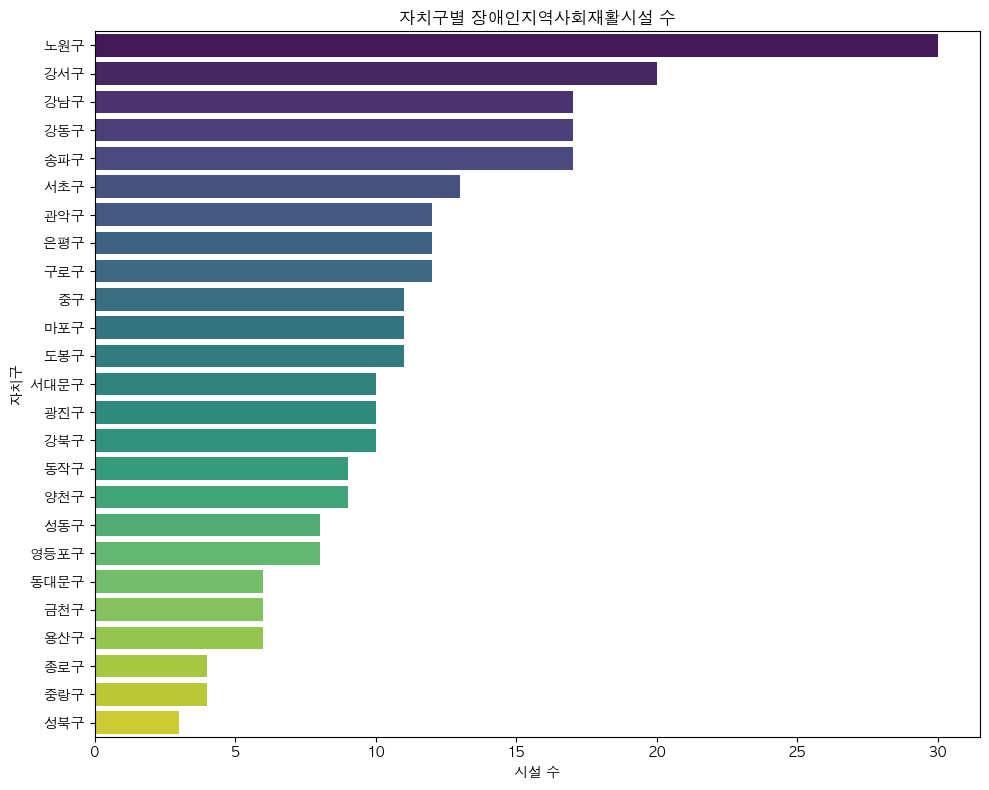

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

district_counts = data.groupby("JRSD_SGG_NM").size().sort_values(ascending=False).reset_index(name="시설수")
plt.figure(figsize=(10, 8))
sns.barplot(data=district_counts, x="시설수", y="JRSD_SGG_NM", palette="viridis")
plt.xlabel("시설 수")
plt.ylabel("자치구")
plt.title("자치구별 장애인지역사회재활시설 수")
plt.tight_layout()
plt.show()

## 자치구별 소득 불러오기

In [21]:
import io
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import ssl, certifi

step = 500
start = 1
chunks = []
while True:
    end = start + step - 1
    income_url = f"http://openapi.seoul.go.kr:8088/{api_key}/xml/trdarNcmCnsmp/{start}/{end}/"
    income_resp = requests.get(income_url, timeout=20)
    chunk = pd.read_xml(io.StringIO(income_resp.text), xpath=".//row")
    if chunk is None or len(chunk) == 0:
        break
    chunks.append(chunk)
    if len(chunk) < step:
        break
    start += step
income_raw = pd.concat(chunks, ignore_index=True)
income_raw["prefix"] = income_raw["TRDAR_CD"].astype(str).str[:4]

ssl_ctx = ssl.create_default_context(cafile=certifi.where())
income_locator = Nominatim(user_agent="seoul_welfare_income", ssl_context=ssl_ctx)
income_geocode = RateLimiter(income_locator.geocode, min_delay_seconds=1)

prefix_map = {}
for prefix, name in income_raw.groupby("prefix")["TRDAR_CD_NM"].first().items():
    district = None
    for query in [name, f"서울 {name}", f"서울특별시 {name}"]:
        loc = income_geocode(query)
        if loc and loc.raw.get("address"):
            addr = loc.raw["address"]
            for key in ["city_district", "county", "state_district", "suburb", "city"]:
                val = addr.get(key)
                if val and (val.endswith("구") or val.endswith("-gu") or val.endswith("gu")):
                    district = val.replace("-gu", "구").replace("gu", "구")
                    break
        if district:
            break
    prefix_map[prefix] = district

income_raw["JRSD_SGG_NM"] = income_raw["prefix"].map(prefix_map)
income = income_raw.dropna(subset=["JRSD_SGG_NM"]).groupby("JRSD_SGG_NM", as_index=False)["MT_AVRG_INCOME_AMT"].mean()
income = income.rename(columns={"MT_AVRG_INCOME_AMT": "평균소득"})
income.head()

,JRSD_SGG_NM,평균소득


## 자치구별 소득 그래프

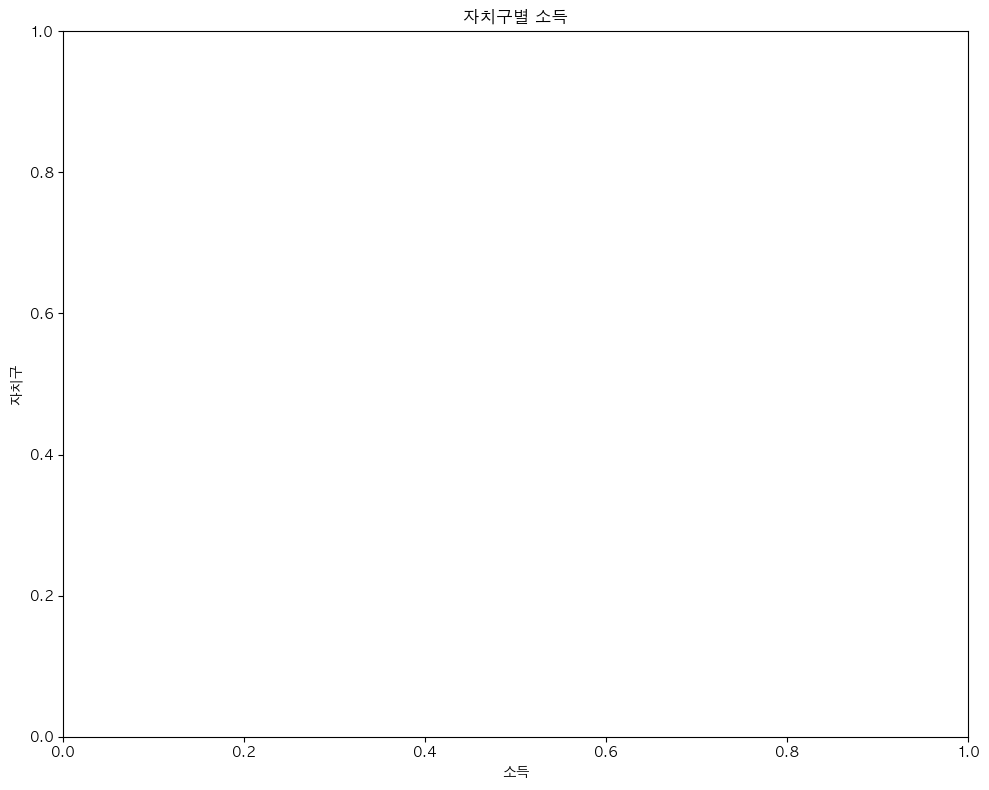

In [22]:
plt.figure(figsize=(10, 8))
sns.barplot(data=income.sort_values('평균소득', ascending=False), x='평균소득', y='JRSD_SGG_NM', palette='magma')
plt.xlabel('소득')
plt.ylabel('자치구')
plt.title('자치구별 소득')
plt.tight_layout()
plt.show()

## 시설 수 대비 소득 비교

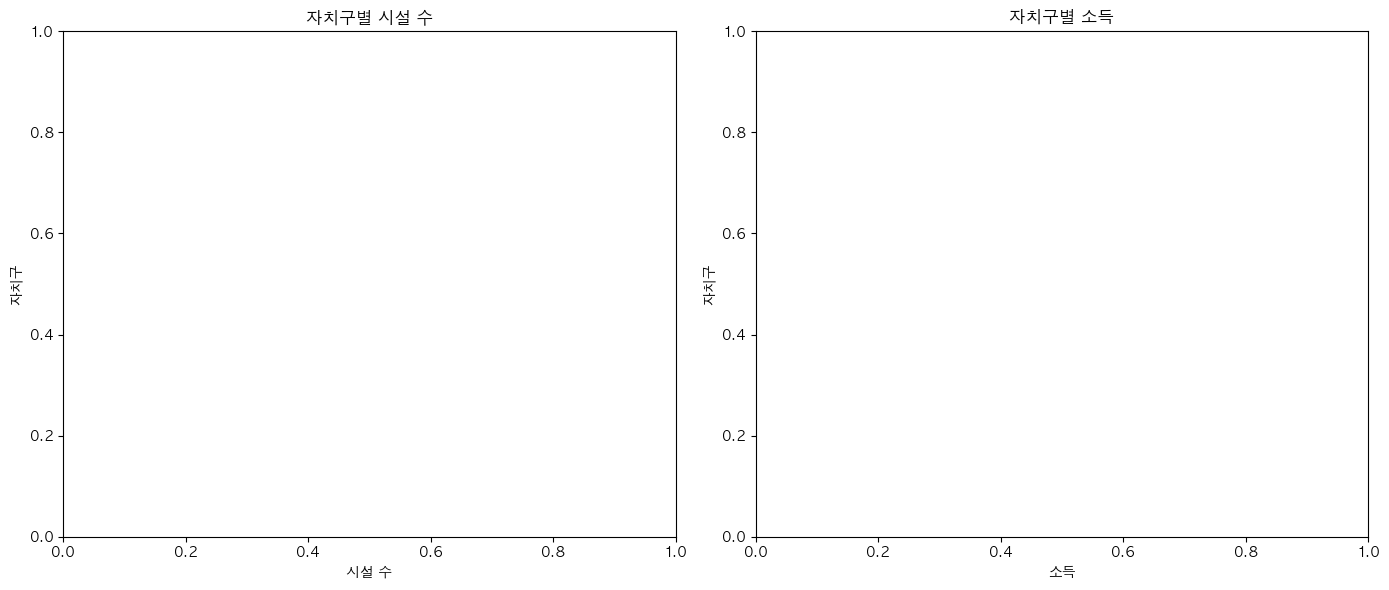

In [19]:
merged = district_counts.merge(income, on='JRSD_SGG_NM', how='inner')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=merged.sort_values('시설수', ascending=False), x='시설수', y='JRSD_SGG_NM', ax=axes[0], palette='viridis')
axes[0].set_xlabel('시설 수')
axes[0].set_ylabel('자치구')
axes[0].set_title('자치구별 시설 수')
sns.barplot(data=merged.sort_values('평균소득', ascending=False), x='평균소득', y='JRSD_SGG_NM', ax=axes[1], palette='magma')
axes[1].set_xlabel('소득')
axes[1].set_ylabel('자치구')
axes[1].set_title('자치구별 소득')
plt.tight_layout()
plt.show()